# Pryngles module: orbit


## External modules

In [1]:
#@external
from pryngles import *
import numpy as np
import rebound as rb
from tqdm import tqdm
from anytree import NodeMixin,RenderTree,ZigZagGroupIter
#@end:external

## Constants

In [2]:
#@consts:orbit
REBOUND_ORBITAL_PROPERTIES=dict(
    #Mass
    m=0,
    #Cartesian coordinates
    x=0,y=0,z=0,vx=0,vy=0,vz=0,
    #Semi major axis, true anomaly, eccentricity
    a=1,f=0,e=0,
    #Periapsis argument, inclination, longitude of the ascending node
    omega=0,inc=0,Omega=0,
    #Mean anomaly, eccentric anomaly, time of periapsis passage
    M=0,E=0,T=0,
    #true longitude (Omega + omega + f), mean anomaly (Omega + omega + M)
    theta=0,l=0,
)

REBOUND_CARTESIAN_PROPERTIES=dict(
    #Cartesian coordinates
    x=0,y=0,z=0,vx=0,vy=0,vz=0,    
)
#@end:consts

## Orbit of Hierarchical N-body system

### Class orbital body

In [3]:
#@class
class Orbody(PrynglesCommon,NodeMixin):
    """Orbital body
    """    
    def __init__(self,name=None,parent=None,**elements):
        
        #Basic attributes
        self.name='body' if name is None else name
        self.parent=parent
        
        #Add initial elements to attributes
        for element in elements:
            if element in REBOUND_ORBITAL_PROPERTIES:
                self.__dict__[element]=elements[element]
            else:
                raise ValueError(f"Element {element} not identified.")
        self.elements=elements

    def show_tree(self):
        print(RenderTree(self))
#@end:class

In [4]:
#@test:template
def test_orbody(self):

    S=Orbody(m=1)
    P=Orbody(parent=S,m=0.1,a=1,e=0.5)

    print(S.m,S.elements)
    print(P.m,P.elements)

    S.show_tree()

class Test(unittest.TestCase):pass
Test.test_orbody=test_orbody
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

1 {'m': 1}
0.1 {'m': 0.1, 'a': 1, 'e': 0.5}
└── <__main__.Orbody object at 0x7fb8f1dc6ca0>



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Class Orbit

#### Docstring

In [5]:
#@docstring:Orbit
Orbit_doc="""Hierarchical N-body system.

Initialization parameters+:

    m1,m2: mixed, default = 1:
        If m1 (m2) is a number, this is the mass of the first body.
        If m1 (m2) is an instance of Orbit, this is a children system.

    elements: dictionary:
        Dictionary with the elements provided to indicate the location of the relative 
        vector of the system.
        
        Valid orbital elements are:
            
            a=1,f=0,e=0: 
                Semi major axis, true anomaly, eccentricity.
            
            omega=0,inc=0,Omega=0:
                Periapsis argument, inclination, longitude of the ascending node.

            M=0,E=0,T=0:
                Mean anomaly, eccentric anomaly, time of periapsis passage.
                
            theta=0,l=0:
                True longitude (Omega + omega + f), mean longitude (Omega + omega + M).

    R: array (3), default = [0,0,0]
        Initial position of the center of mass.
    
    V: array (3), default = [0,0,0]
        Initial velocity of the center of mass.
    
Secondary attributes:

    m1, m2: float:
        Masses of the particles.

    Mtot: float:
        Total mass of the system.
    
    sub_sim: Rebound Simulation:
        Simulation corresponding to the motion of the two particles.
        
    sim: Rebound simulation:
        Simulation corresponding to all particles in the system.

Key methods:

    get_positions():
    
        Returns:
            states: list (N) of dictionaries:
                List of dictionaries having the state vector x,y,z,vx,vy,vz of 
                each particle.

All methods:
    See Misc.get_methods(Orbit)
    
Examples:

    Complex system: two binaries orbited by a further away object:
    
        S1=Orbit(m1=1,m2=1,a=1,e=0.7,M=0)
        S2=Orbit(m1=1,m2=1,a=1,e=0,M=0)
        S3=Orbit(S1,S2,a=5,e=0)
        S4=Orbit(S3,m2=1,a=20,e=0,E=45*Consts.deg)
        S4.ensamble_system()
        Plot.animate_rebound(S4.sim)
        
    Planet with a moon:
        units=["au","msun","yr"]
        orb=Orbit(
            m1=1,
            m2=Orbit(m1=1e-3,m2=1e-7,a=0.5,e=0.0,units=units),
            units=units,
            a=20,e=0.0)
        orb.calculate_orbit()
        sim,states=orb.get_states()
        Plot.animate_rebound(sim)
        
    Simple system:
        units=["au","msun","yr"]
        sim,states=Orbit(m1=1.0,m2=1e-3,units=units,a=0.1,e=0.0).calculate_orbit().get_states()
        
""";
#@end:docstring

#### Class

In [6]:
#@class
class Orbit(PrynglesCommon):
    ORBIT_SIMULATIONS=[]    
    def __init__(self,
                 name=None,
                 units=None,
                 m1=1,m2=1,
                 R=np.array([0,0,0]),
                 V=np.array([0,0,0]),
                 **elements):

        #System
        self.name='system' if name is None else name
        
        #Global simulation
        self.sim=rb.Simulation()
        if units:
            self.units=units
        else:
            self.units=["au","msun","yr2pi"]
        self.sim.units=self.units

        #Particles
        self.p1=m1
        self.p2=m2
        
        #Periods
        self.Ps=[]
        
        #Check first system
        qmixed=False
        if isinstance(self.p1,Orbit):
            self.m1=self.p1.Mtot
            qmixed=True
        elif isinstance(self.p1,float) or isinstance(self.p1,int):
            self.m1=self.p1
        else:
            raise ValueError(f"Type of first componente ({type(m1)}) not recognized.  It should be a float or an Orbit instance.")
        
        #Check second system
        if isinstance(self.p2,Orbit):
            self.m2=self.p2.Mtot
            qmixed=True
        elif isinstance(self.p2,float) or isinstance(self.p2,int):
            self.m2=self.p2
        else:
            raise ValueError(f"Type of Second component ({type(m2)}) not recognized.  It should be a float or an Orbit instance.")
                
        if not qmixed and (sum(R)!=0 or sum(V)!=0):
            raise ValueError(f"You cannot provide a center of mass position and velocity for a non-mixed system.")
        
        #Total mass
        self.Mtot=self.m1+self.m2
        
        #Add initial elements to attributes
        for element in elements:
            if element in REBOUND_ORBITAL_PROPERTIES:
                self.__dict__[element]=elements[element]
            else:
                raise ValueError(f"Element {element} not identified.")
                
        #Update states
        self._update_states(R,V)
        
    def _update_states(self,R=np.array([0,0,0]),V=np.array([0,0,0])):
        """Update state of the particles
        """        
        #Create rebound options
        self._rb_options={k:v for k,v in self.__dict__.items() if k in REBOUND_ORBITAL_PROPERTIES}  
        self._rb_options.update(dict(m=0))
        
        #Create rebound simulation
        sim=rb.Simulation()
        sim.units=self.units
        sim.add(m=self.Mtot)
        sim.add(**self._rb_options)
        
        #Relative vector
        self.r=np.array(sim.particles[1].xyz)
        self.v=np.array(sim.particles[1].vxyz)
        del sim
        
        #Calculate positions of components
        self.r1=R-self.m2/self.Mtot*self.r
        self.v1=V-self.m2/self.Mtot*self.v
        
        if isinstance(self.p1,Orbit):
            self.p1._update_states(self.r1,self.v1)
            
        self.r2=R+self.m1/self.Mtot*self.r
        self.v2=V+self.m1/self.Mtot*self.v                
        if isinstance(self.p2,Orbit):
            self.p2._update_states(self.r2,self.v2)
            
        #Create a simulation of this system
        self.sub_sim=rb.Simulation()
        self.sub_sim.units=self.units
        self.sub_sim.add(m=self.m1,
                         x=self.r1[0],y=self.r1[1],z=self.r1[2],
                         vx=self.v1[0],vy=self.v1[1],vz=self.v1[2])
        self.sub_sim.add(m=self.m2,
                         x=self.r2[0],y=self.r2[1],z=self.r2[2],
                         vx=self.v2[0],vy=self.v2[1],vz=self.v2[2])

        Orbit.ORBIT_SIMULATIONS+=[self.sub_sim]

    def calculate_orbit(self,sim=None):
        """Ensamble Hierarchical N-body system.
        
        Parameters:
            sim: Rebound Simulation, default = None:
                This is used for recursion purposes.  
                Normally is set to None.
        
        Return:
            orbit: Orbit object:
                Used for nested purposes, 
                Example: orbit.calculate_orbit().get_states()
        """
        if sim is None:
            sim=self.sim
            
        if isinstance(self.p1,Orbit):
            self.p1.calculate_orbit(sim)
        else:
            sim.add(m=self.m1,
                    x=self.r1[0],y=self.r1[1],z=self.r1[2],
                    vx=self.v1[0],vy=self.v1[1],vz=self.v1[2])

        if isinstance(self.p2,Orbit):
            p=self.p2.calculate_orbit(sim)
        else:
            sim.add(m=self.m2,
                    x=self.r2[0],y=self.r2[1],z=self.r2[2],
                    vx=self.v2[0],vy=self.v2[1],vz=self.v2[2])
            
        for p in sim.particles[1:]:
            self.Ps+=[p.P]

        return self
            
    def get_states(self):
        """Get positions of particles in the system
        
        Returns:
            states: list (N) of dictionaries:
                List of dictionaries having the state vector x,y,z,vx,vy,vz of 
                each particle.        
        """
        states=[]
        for p in self.sim.particles:
            states+=[
                dict(m=p.m,x=p.x,y=p.y,z=p.z,vx=p.vx,vy=p.vy,vz=p.vz)
            ]
        return self.sim,states
    
#@end:class

In [7]:
#@test:template
def test_Orbit(self):

    global S4

    #Quintuple system
    S1=Orbit(m1=1,m2=1,a=1,e=0.7,M=0)
    S2=Orbit(m1=1,m2=1,a=1,e=0,M=0)
    S3=Orbit(m1=S1,m2=S2,a=5,e=0)
    S4=Orbit(m1=S3,m2=1,a=20,e=0,E=45*Consts.deg)
    S4.calculate_orbit()
    print(S4.get_states())
    print(S4.Ps)

    #Using custom units
    #Quintuple system

    #Initialize positions
    units=['au','msun','yr']
    hn=Orbit(
        m1=1,
        m2=Orbit(m1=1e-3,m2=1e-7,a=0.5,e=0.0,units=units),
        units=units,
        a=20,e=0.0)
    hn.calculate_orbit()
    sim,states=hn.get_states()
    print(states)

    #SImple 

    #Use this code to animate:
    #Plot.animate_rebound(S4.sim)

class Test(unittest.TestCase):pass
Test.test_Orbit=test_Orbit
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

(<rebound.simulation.Simulation object at 0x7fb8f1de3dc0, N=5, t=0.0>, [{'m': 1.0, 'x': -5.47842712474619, 'y': -2.82842712474619, 'z': 0.0, 'vx': 0.07071067811865474, 'vy': -2.2011750966789583, 'vz': 0.0}, {'m': 1.0, 'x': -5.1784271247461895, 'y': -2.82842712474619, 'z': 0.0, 'vx': 0.07071067811865474, 'vy': 1.1653265494417333, 'vz': 0.0}, {'m': 1.0, 'x': -0.8284271247461903, 'y': -2.82842712474619, 'z': 0.0, 'vx': 0.07071067811865474, 'vy': -0.3306038638052443, 'vz': 0.0}, {'m': 1.0, 'x': 0.1715728752538097, 'y': -2.82842712474619, 'z': 0.0, 'vx': 0.07071067811865474, 'vy': 1.0836096985678507, 'vz': 0.0}, {'m': 1.0, 'x': 11.313708498984761, 'y': 11.31370849898476, 'z': 0.0, 'vx': -0.28284271247461895, 'vy': 0.282842712474619, 'vz': 0.0}])
[4.4428829381584665, 12.74284608459776, -112.2111774360127, 251.32741228718336]
[{'m': 1.0, 'x': -0.01998201598581259, 'y': 0.0, 'z': 0.0, 'vx': 0.0, 'vy': -0.0014043748232577592, 'vz': 0.0}, {'m': 0.001, 'x': 19.97996798901369, 'y': 0.0, 'z': 0.0, 


----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


## Class OrbitUtil

In [8]:
#@class
class OrbitUtil(PrynglesCommon):
    """Celestial mechanics utilities
    """
    
    def build_system(pair,units=None):
        """Builds a hierarchichal N-body system
        
        Parameters:
            pair: list (2) of Orbody objects:
                List with two objects forming the system.
                
            units: list of strings, default = ['au','msun','yr2pi']:
                Units used in calculations following the conventions and signs of rebound.
                The order SHOULD always be MKS: length, mass, time (in that order).
                
        Return:
            orbit: object of the class Orbit:
                Hierarchical N-body system.
                
        Examples:
            #Objects
            S1=Orbody(name="Star1",m=1)
            P1S1=Orbody(name="Planet1Star1",parent=S1,m=0.1,a=1,e=0.2)
            M1P1=Orbody(name="Moon1Planet1",parent=P1S1,m=0.01,a=0.1,e=0.5)
            SM1M1=Orbody(name="Moon1Planet1",parent=P1S1,m=0.001,a=0.01,e=0.2)

            S2=Orbody(name="Star1",m=1,a=5,e=0.3)
            P1S2=Orbody(name="Planet1Star2",parent=S2,m=0.1,a=1,e=0.5)

            #All possible systems
            #Simple binary
            orbital_tree=[S1,S2]
            orbit,pelements=build_system(orbital_tree)
                        
            #Star and planet with moon
            orbital_tree=[S1,[P1S1,M1P1]]
            orbit,pelements=build_system(orbital_tree)
            
            #Star and planet with moon and minimoon
            orbital_tree=[S1,[P1S1,[M1P1,SM1M1]]]
            orbit,pelements=build_system(orbital_tree)
            
            #Two stars with their planets
            orbital_tree=[[S1,P1S1],[S2,P1S2]]
            orbit,pelements=build_system(orbital_tree)
            
            #Two stars with planets and moon
            orbital_tree=[[S1,[P1S1,M1P1]],[S2,P1S2]]
            orbit,pelements=build_system(orbital_tree)
            
            #Two stars with planets, moon and minimoon
            orbital_tree=[[S1,[P1S1,[M1P1,SM1M1]]],[S2,P1S2]]
            orbit,pelements=build_system(orbital_tree)

            #You may check the result using:
            orbit.calculate_orbit()
            Plot.animate_rebound(orbit.sim,color='b',ms=2)
        """
        
        p1,p2=pair

        if type(p1) is list:
            m1,pelements=OrbitUtil.build_system(p1,units)
        else:
            m1=p1.m
            pelements=p1.elements.copy()

        if type(p2) is list:
            m2,elements=OrbitUtil.build_system(p2,units)
        else:
            m2=p2.m
            elements=p2.elements

        Orbit.ORBIT_SIMULATIONS=[]
        orbit=Orbit(m1=m1,m2=m2,units=units,**elements)

        return orbit,pelements
#@end:class

In [9]:
#@test:template
def test_build(self):

    global orbit
    
    units=['au','msun','yr']
    S1=Orbody(name="Star1",m=1)
    P1S1=Orbody(name="Planet1Star1",parent=S1,m=0.1,a=1,e=0.2)
    P2S1=Orbody(name="Planet1Star1",parent=S1,m=0.1,a=2,e=0.2)
    M1P1=Orbody(name="Moon1Planet1",parent=P1S1,m=0.01,a=0.1,e=0.5)
    SM1M1=Orbody(name="Moon1Planet1",parent=P1S1,m=0.001,a=0.01,e=0.2)

    S2=Orbody(name="Star1",m=1,a=5,e=0.3)
    P1S2=Orbody(name="Planet1Star2",parent=S2,m=0.1,a=1.5,e=0.5)

    orbital_tree=[[S1,[P1S1,[M1P1,SM1M1]]],[S2,P1S2]]
    orbit,pelements=OrbitUtil.build_system(orbital_tree,units)
    orbit.calculate_orbit()
    #Plot.animate_rebound(orbit.sim,filename="tmp/hierarchical-system.mp4",color='b',ms=3)

class Test(unittest.TestCase):pass
Test.test_build=test_build
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


In [10]:
#@end:module

## Playing ground

In [11]:
from celluloid import Camera

#@method:Plot
def animate_rebound(sim,filename=None,tini=0,tend=None,nsnap=None,interval=100,axis=False,traces=False,**plot_args):
    """Animate a rebound simulation.
    """
    
    default_plot_args=dict(
        marker='o',
        color='r'
    )
    default_plot_args.update(plot_args)
    
    verbosity=Verbose.VERBOSITY
    Verbose.VERBOSITY=VERB_NONE
    
    fig,ax=plt.subplots()

    if not traces:
        camera=Camera(fig)

    #Get the period of the longest osculant orbit
    P=-1
    for p in sim.particles[1:]:
        P=p.P if p.P>P else P
    
    #Choose properly tend and nsnap
    tend=P if tend is None else tend
    nsnap=int(tend/(P/100)) if nsnap is None else nsnap
    
    if traces:
        sim.move_to_com()
        for p in sim.particles:
            xyz=p.xyz
            ax.plot(xyz[0],xyz[1],marker="*",color='k',ms=10,zorder=1000)

    #Simulate
    for i,t in enumerate(tqdm(np.linspace(tini,tend,nsnap))):
        sim.integrate(t)
        sim.move_to_com()
        
        for p in sim.particles:
            xyz=p.xyz
            ax.plot(xyz[0],xyz[1],**default_plot_args)
         
        if not traces:
            ax.text(0.5,1,f"t = {sigfig.round(t,3)} (snap {i+1}/{nsnap})",
                    transform=ax.transAxes,
                    ha='center',va='bottom')

            camera.snap()
    
    if axis:
        ax.grid()
    else:
        ax.axis("off")
    ax.axis("equal")

    if not traces:
        anim=camera.animate(interval=interval)    
        Verbose.VERBOSITY=verbosity

        if filename is not None:
            if 'gif' in filename:
                anim.save(filename)
                return anim
            elif 'mp4' in filename:
                ffmpeg=animation.writers["ffmpeg"]
                metadata = dict(title='Pryngles Spangler Animation',
                                artist='Matplotlib',
                                comment='Movie')
                w=ffmpeg(fps=15,metadata=metadata)
                anim.save(filename,w)
                return anim
            else:
                raise ValueError(f"Animation format '{filename}' not recognized")
        else:
            return anim

        return anim
#@end:method
Plot.animate_rebound=animate_rebound

In [12]:
units=['au','msun','yr']
S1=Orbody(name="Star1",m=1)
P1S1=Orbody(name="Planet1Star1",parent=S1,m=0.1,a=1,e=0.2)
P2S1=Orbody(name="Planet1Star1",parent=S1,m=0.1,a=2,e=0.2)
M1P1=Orbody(name="Moon1Planet1",parent=P1S1,m=0.01,a=0.1,e=0.5)
SM1M1=Orbody(name="Moon1Planet1",parent=P1S1,m=0.001,a=0.01,e=0.2)
S2=Orbody(name="Star1",m=1,a=5,e=0.3)
P1S2=Orbody(name="Planet1Star2",parent=S2,m=0.1,a=1.5,e=0.5)

#All possible systems
#Simple binary
orbital_tree=[S1,S2]
#Star and planet with moon
orbital_tree=[[P1S1,M1P1],S1]
#Star and planet with moon and minimoon
orbital_tree=[S1,[P1S1,[M1P1,SM1M1]]]
#Two stars with their planets
orbital_tree=[[S1,P1S1],[S2,P1S2]]
#Two stars with planets and moon
orbital_tree=[[S1,[P1S1,M1P1]],[S2,P1S2]]
#One star, two planets
orbital_tree=[[S1,P1S1],P2S1]
#Two stars with planets, moon and minimoon
orbital_tree=[[S1,[P1S1,[M1P1,SM1M1]]],[S2,P1S2]]
#orbital_tree=[[S1,[P1,M1P1]],[S2,P1S2]]
orbit,pelements=OrbitUtil.build_system(orbital_tree,units)
orbit.calculate_orbit()
Plot.animate_rebound(orbit.sim,filename="tmp/hierarchical-system.mp4",color='b',ms=2)

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [00:00<00:00, 204.69it/s]


In [13]:
Plot.animate_rebound(Orbit.ORBIT_SIMULATIONS[5])

IndexError: list index out of range

Hierarchical system MC course:

In [14]:
units=['au','msun','yr']
P=Orbody(name="Planet1",m=1)
M1=Orbody(name="Moon1",parent=P,m=0.02,x=1,vy=5)
M2=Orbody(name="Moon2",parent=P,m=0.01,x=1.5,vy=5)

#All possible systems
orbital_tree=[[P,M1],M2]
orbit,pelements=OrbitUtil.build_system(orbital_tree,units)
orbit.calculate_orbit()
Plot.animate_rebound(orbit.sim,filename="tmp/system1.mp4",color='b',ms=2)

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [00:00<00:00, 490.73it/s]


In [37]:
import pymcel as pc

In [52]:
sistema=[
    dict(m=1,r=[0,0,0],v=[0,0,0]),
    dict(m=0.02,r=[1,0,0],v=[0,0.7,0]),
    dict(m=0.01,r=[1.5,0,0],v=[0,0.8,0]),
]

In [53]:
ts=np.linspace(0,10,100)
rs,vs,rps,vps,constantes=pc.ncuerpos_solucion(sistema,ts)

<IPython.core.display.Javascript object>


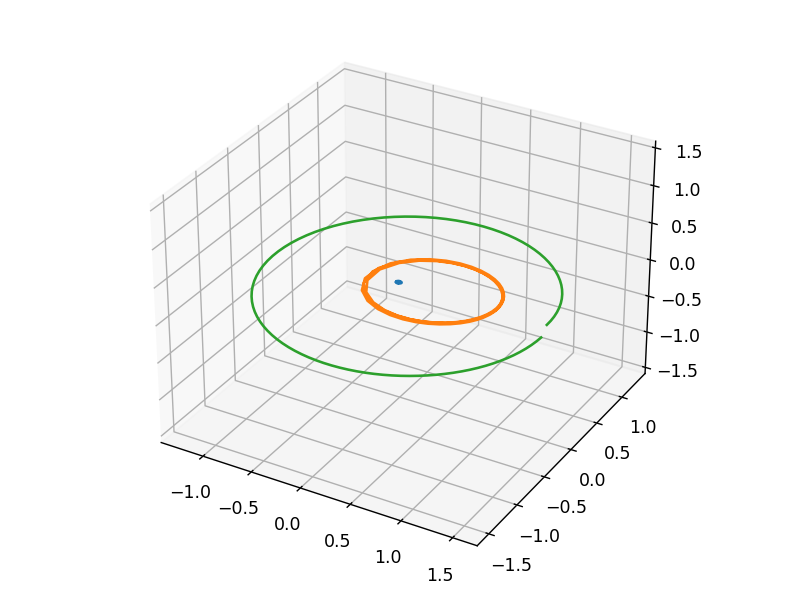

<IPython.core.display.Javascript object>


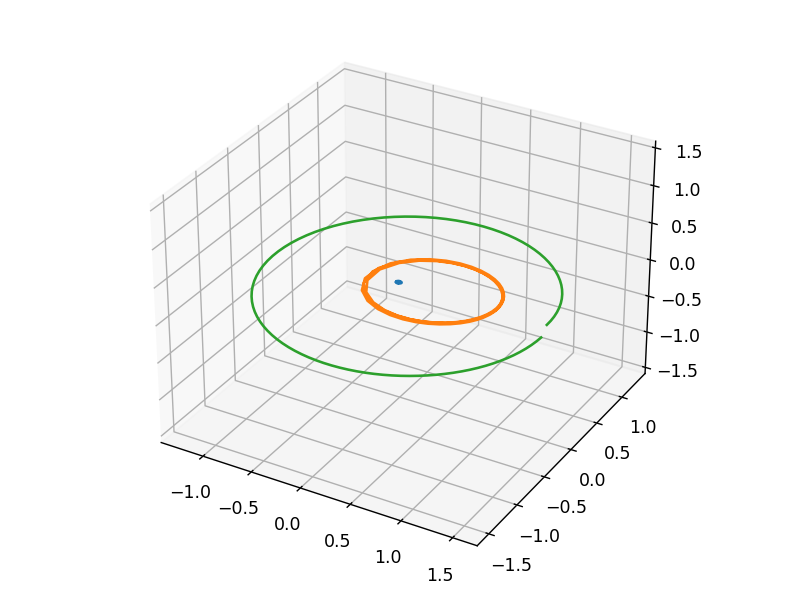

In [54]:
pc.plot_ncuerpos_3d(rps,vps)